## MODULE 3 - Normalization and Dimensional Reduction
### (2024) INTRODUCTORY SPATIAL 'OMICS ANALYSIS
#### HYBRID : TORONTO & ZOOM
### __________________________________________


#### 9TH JULY 2024 
#### Instructor : Shamini Ayyadhury

_______________________________________________________

#### A. Normalizing your data
##### In this module we try out a few different normalization/transformation methods and test its effects on differential expression analysis

1. log normalization
2. SCTransform
3. DESeq

OBJECTIVES
###### 1. Using what we have understood in our lecture, we will implement 3 of the above normalization/transformation methods
###### 2. Next, instead of performing leiden clustering, we will try differential analysis and evaluate if there are differences in gene expression
###### 3. Finally, we will have a short brainstorming session based on the results to see 
* How to select the best normalization methods
* Does normalization affect affect leiden clustering?
* How does normalization affect differential testing?


#### B. PRE-PROCESSING YOUR DATA
In this section participants will review the transcripts file. The transcripts file contains the identity, position of each transcript from genes and controls. Here we will start from this file and review the quality values and assess cut-off margins. 

OBJECTIVES
###### 1. Process transcript file and evaluate quality of gene and control transcripts
###### 2. Assess the distribution of transcripts across 'field of view'.
###### 3. Derive the gene matrix, counts matrix and cell centroid matrix from the transcript file

DATASETS WE WILL USE
* We will use the FFPE half-brain xenium sample - "TgCRND8 17.9 months" processed adata from module 2 and incorporate an additional metadata that carries cell-type labels. 
    * The metadata was obtained by transferring cell-type labels from a single cell dataset (Allen mouse brain), to the current xenium dataset.
    * The supplementary code used for this label transfer (in R) is provided 


In [1]:
### import the following libraries

### Packages for general system functions, miscellaneous operating system interfaces, warning control system
import sys ### general system functions
import os ### miscellaneous operating system interfaces
import warnings ### warning control system
import psutil
warnings.filterwarnings('ignore') ### ignore warnings

### Packages for data manipulation and analysis, data visualization
import pandas as pd ### data manipulation and analysis for tabular data in python
import matplotlib.pyplot as plt ### plotting library for the Python programming language and its numerical mathematics extension NumPy
import seaborn as sns ### data visualization library based on matplotlib (my personal favourite over matplotlib)
import numpy as np ### support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays
import scanpy as sc ### single-cell RNA-seq analysis in Python
import pydeseq2

from PIL import Image ### python imaging library

import pickle as pkl ### python object serialization library

from pydeseq2.dds import DeseqDataSet 
from pydeseq2.default_inference import DefaultInference
from pydeseq2.preprocessing import deseq2_norm



sys.path.append('/home/shamini/data/projects/spatial_workshop/')
sys.path.append('/home/shamini/data/projects/spatial_workshop/Banksy_py/')

import pre_processing_fnc as ppf


In [2]:
color = [
"#ebac23",
#1yellow

"#b80058",
#2lipstick

"#008cf9",
#3azure

"#006e00",
#4green

"#00bbad",
#5caribbean

"#d163e6",
#6lavender

"#b24502",
#7brown

"#ff9287",
#8coral

"#5954d6",
#9indigo

"#00c6f8",
#10turquoise

"#878500",
#11olive

"#00a76c",
#12jade

"#bdbdbd",
#13green

"#005900",
#14green

"#000078",
#15blue

"#490d00",
#16brown

"#8a034f",
#17pink

"#005a8a",
#18orient

"#443500",
#19cola

"#274d52",
#20plantation

"#c7a2a6"]
#21eunry

aaabiggh-1         Astro
aaacfoel-1         Astro
aaaeefil-1         Astro
aaaehidd-1    Macrophage
aaagcbkg-1         Astro
                 ...    
oindmjog-1          VLMC
oinecaba-1          VLMC
oinehfmf-1          VLMC
oinemiil-1          VLMC
oingfoec-1            L4
Name: predicted.id, Length: 60099, dtype: object

AnnData object with n_obs × n_vars = 60099 × 347
    obs: 'gene_counts', 'neg_counts', 'x_location', 'y_location', 'n_counts'
    var: 'genes', 'n_cells'
    uns: 'gene_count_mean', 'gene_count_median'

array([[4, 2, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 5, ..., 0, 0, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

array([[4, 2, 1, ..., 0, 0, 1],
       [0, 0, 1, ..., 0, 0, 1],
       [0, 0, 5, ..., 0, 0, 2],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

'Memory usage: 1523.95 MB'

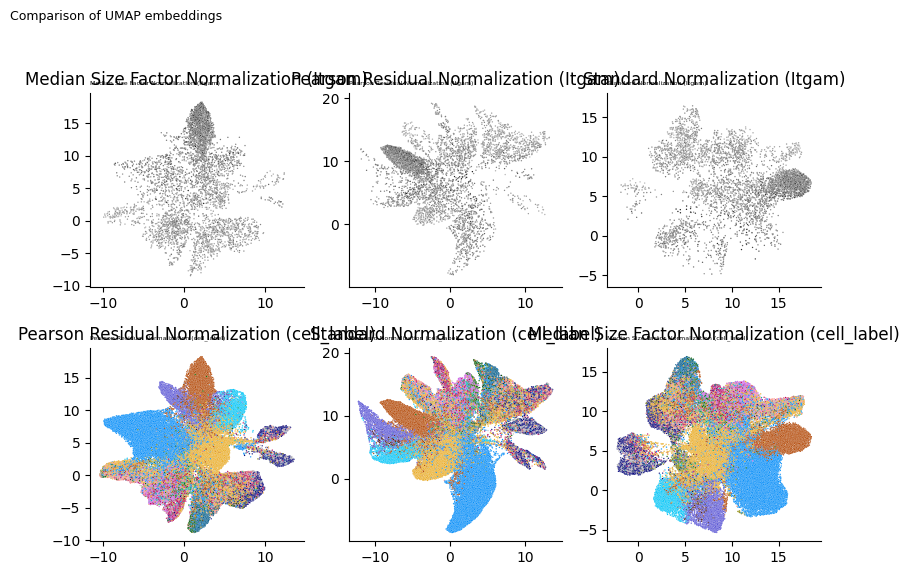

'Memory usage: 1532.38 MB'

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Extract UMAP coordinates
medUMAP_coords = adata.obsm['medUMAP']
pearsonUMAP_coords = adata.obsm['pearsonUMAP']
stdUMAP_coords = adata.obsm['stdUMAP']

# Extract Itgam expression and convert to pandas Series for sorting
Itgam = pd.Series(adata[:, adata.var['genes'] == 'Itgam'].X.flatten(), name='Itgam')

# Sort Itgam expression and get sorted indices
Itgam_sorted = Itgam.sort_values()
sorted_indices = Itgam_sorted.index

# Extract and sort cell labels according to Itgam
cell_label = adata.obs['cell_label'].values
cell_label_sorted = cell_label[sorted_indices]

# Sort UMAP coordinates
medUMAP_coords_sorted = medUMAP_coords[sorted_indices, :]
pearsonUMAP_coords_sorted = pearsonUMAP_coords[sorted_indices, :]
stdUMAP_coords_sorted = stdUMAP_coords[sorted_indices, :]

fig, axes = plt.subplots(2, 3, figsize=(8, 6))
fig.suptitle('Comparison of UMAP embeddings', fontsize=9, x=0.1)

# Plot Median Size Factor Normalization (Itgam)
sns.scatterplot(x=medUMAP_coords_sorted[:, 0], y=medUMAP_coords_sorted[:, 1], hue=Itgam_sorted, palette='Greys', s=1, ax=axes[0, 0])
axes[0, 0].set_title('Median Size Factor Normalization (Itgam)')

# Plot Pearson Residual Normalization (cell_label)
sns.scatterplot(x=medUMAP_coords_sorted[:, 0], y=medUMAP_coords_sorted[:, 1], hue=cell_label_sorted, palette=color, s=1, ax=axes[1, 0])
axes[1, 0].set_title('Pearson Residual Normalization (cell_label)')

# Plot Pearson Residual Normalization (Itgam)
sns.scatterplot(x=pearsonUMAP_coords_sorted[:, 0], y=pearsonUMAP_coords_sorted[:, 1], hue=Itgam_sorted, palette='Greys', s=1, ax=axes[0, 1])
axes[0, 1].set_title('Pearson Residual Normalization (Itgam)')

# Plot Standard Normalization (cell_label)
sns.scatterplot(x=pearsonUMAP_coords_sorted[:, 0], y=pearsonUMAP_coords_sorted[:, 1], hue=cell_label_sorted, palette=color, s=1, ax=axes[1, 1])
axes[1, 1].set_title('Standard Normalization (cell_label)')

# Plot Standard Normalization (Itgam)
sns.scatterplot(x=stdUMAP_coords_sorted[:, 0], y=stdUMAP_coords_sorted[:, 1], hue=Itgam_sorted, palette='Greys', s=1, ax=axes[0, 2])
axes[0, 2].set_title('Standard Normalization (Itgam)')

# Plot Median Size Factor Normalization (cell_label)
sns.scatterplot(x=stdUMAP_coords_sorted[:, 0], y=stdUMAP_coords_sorted[:, 1], hue=cell_label_sorted, palette=color, s=1, ax=axes[1, 2])
axes[1, 2].set_title('Median Size Factor Normalization (cell_label)')

for ax in axes.flatten():
    ax.get_legend().remove()
    ax.set_title(ax.get_title(), fontsize=4.5, loc='left')

sns.despine()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit title and labels
plt.show()

ppf.get_memory_usage()  # Monitor memory usage


In [11]:
#inference = DefaultInference(n_cpus=3)


#dds = DeseqDataSet(counts= pd.DataFrame(adata.raw.X.copy()), metadata=adata.obs, refit_cooks=True, inference=inference, design_factors=['cell_label'])

#dds.fit_size_factors()
#dds.obsm["size_factors"]
#deseq2_norm(dds)

#dds.fit_genewise_dispersions()

#dds.varm["genewise_dispersions"]


#dds.fit_dispersion_trend()
#dds.uns["trend_coeffs"]
#dds.varm["fitted_dispersions"]

#dds.fit_dispersion_prior()
#print(
#    f"logres_prior={dds.uns['_squared_logres']}, sigma_prior={dds.uns['prior_disp_var']}"
#)

#dds.fit_MAP_dispersions()
#dds.varm["MAP_dispersions"]
#dds.varm["dispersions"]

#dds.fit_LFC()
#dds.varm["LFC"]

ppf.get_memory_usage() ### monitor memory usage

'Memory usage: 1532.38 MB'

In [12]:
sys.path.append('/home/shamini/data/projects/spatial_workshop/Banksy_py/')

In [13]:
adata.uns['spatial'] = adata.obs[['x_location', 'y_location']].values
adata.obsm['spatial'] = adata.obs[['x_location', 'y_location']].values

#spatial = adata.obs[['x_location', 'y_location']].copy()

In [15]:
from banksy.main import median_dist_to_nearest_neighbour

# set params
# ==========
plot_graph_weights = True
k_geom = 15 # only for fixed type
max_m = 1 # azumithal transform up to kth order
nbr_weight_decay = "scaled_gaussian" # can also be "reciprocal", "uniform" or "ranked"

# Find median distance to closest neighbours, the median distance will be `sigma`
nbrs = median_dist_to_nearest_neighbour(adata, key = 'spatial')

from banksy.initialize_banksy import initialize_banksy

banksy_dict = initialize_banksy(
    adata,
    ('x_location', 'y_location', 'spatial'),
    k_geom,
    nbr_weight_decay=nbr_weight_decay,
    max_m=max_m,
    plt_edge_hist=False,
    plt_nbr_weights=False,
    plt_agf_angles=False, # takes long time to plot
    plt_theta=False,
)

banksy_dict


Median distance to closest cell = 11.978918604010019

---- Ran median_dist_to_nearest_neighbour in 0.21 s ----


Median distance to closest cell = 11.978918604010019

---- Ran median_dist_to_nearest_neighbour in 0.21 s ----

---- Ran generate_spatial_distance_graph in 0.45 s ----

---- Ran row_normalize in 0.21 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 2.61 s ----

---- Ran generate_spatial_distance_graph in 0.71 s ----

---- Ran theta_from_spatial_graph in 0.63 s ----

---- Ran row_normalize in 0.21 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 3.61 s ----



{'scaled_gaussian': {'weights': {0: <60099x60099 sparse matrix of type '<class 'numpy.float64'>'
   	with 901485 stored elements in Compressed Sparse Row format>,
   1: <60099x60099 sparse matrix of type '<class 'numpy.complex128'>'
   	with 1802970 stored elements in Compressed Sparse Row format>}}}

In [16]:
print(type(banksy_dict[nbr_weight_decay]['weights'][0]))
print(banksy_dict[nbr_weight_decay]['weights'][0].shape)
print(type(adata.X))
print(adata.X.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(60099, 60099)
<class 'numpy.ndarray'>
(60099, 347)


In [17]:
from banksy.embed_banksy import generate_banksy_matrix

### the following are the main hyperparamters for the banksy algorithm
### ------------------------------------------------------------------

resolutions = [0.3] ### clustering resolution for umap
pca_dims = [18] ### Dimensionality to which to reduce data to
lamda_list = [0,.5,1] ### list of lamda values, setting higher value will result in more domain specific clustering

banksy_dict, banksy_matrix = generate_banksy_matrix(adata, banksy_dict, lamda_list, max_m, verbose=False)


Decay Type: scaled_gaussian
Weights Object: {'weights': {0: <60099x60099 sparse matrix of type '<class 'numpy.float64'>'
	with 901485 stored elements in Compressed Sparse Row format>, 1: <60099x60099 sparse matrix of type '<class 'numpy.complex128'>'
	with 1802970 stored elements in Compressed Sparse Row format>}}

Nbr matrix | Mean: -0.01 | Std: 0.49
Size of Nbr | Shape: (60099, 347)
Top 3 entries of Nbr Mat:

[[ 0.11481402  0.16523885  0.47863789]
 [ 0.07742875  0.33324225  0.43537972]
 [-0.28080895  0.6758219   0.17036383]]

AGF matrix | Mean: 0.15 | Std: 0.15
Size of AGF mat (m = 1) | Shape: (60099, 347)
Top entries of AGF:
[[0.23622047 0.25042109 0.18037788]
 [0.36603192 0.28214526 0.1216361 ]
 [0.23860202 0.3113614  0.23323526]]
Ran 'Create BANKSY Matrix' in 0.14 mins
Scale factors squared: [1. 0. 0.]
Scale factors: [1. 0. 0.]
Scale factors squared: [0.5        0.33333333 0.16666667]
Scale factors: [0.70710678 0.57735027 0.40824829]
Scale factors squared: [0.         0.66666667 0

In [18]:
### append non-spatial results to the banksy_dict for comparison

from banksy.main import concatenate_all
banksy_dict['nonspatial'] = {### here we append the non-spatial matrix (adata.X) to obtain the non-spatial clustering results
    0.0: {"adata": concatenate_all([adata.X], 0, adata=adata), }
    }

Scale factors squared: [1.]
Scale factors: [1.]


In [19]:
from banksy_utils.umap_pca import pca_umap

pca_umap(banksy_dict,
         pca_dims = pca_dims,
         add_umap = True,
         plt_remaining_var = False,
         verbose = False)

Current decay types: ['scaled_gaussian', 'nonspatial']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0)

Setting the total number of PC = 18
Original shape of matrix: (60099, 1041)
Reduced shape of matrix: (60099, 18)
------------------------------------------------------------
min_value = -14.962920568598992, mean = 1.0242547409222008e-16, max = 17.395829052932555

Conducting UMAP and adding embeddings to adata.obsm["reduced_pc_18_umap"]
UMAP embedding
------------------------------------------------------------
shape: (60099, 2)


AxisArrays with keys: reduced_pc_18, reduced_pc_18_umap

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.5)

Setting the total number of PC = 18
Original shape of matrix: (60099, 1041)
Reduced shape of matrix: (60099, 18)
------------------------------------------------------------
min_value = -13.390884709578032, mean = -2.953090493257801e-17, max = 14.398293267873878

Conducting UMAP and adding embeddings to adata.obsm["

In [20]:
from banksy.cluster_methods import run_Leiden_partition
seed=329
results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 50,
    num_iterations = -1,
    partition_seed = seed,
    match_labels = True,
    verbose = False
)

Decay type: scaled_gaussian
Neighbourhood Contribution (Lambda Parameter): 0.5
reduced_pc_18 

reduced_pc_18_umap 

PCA dims to analyse: [18]

Setting up partitioner for (nbr decay = scaled_gaussian), Neighbourhood contribution = 0.5, PCA dimensions = 18)

---- Ran find_nn in 54.86 s ----


Nearest-neighbour connectivity graph (dtype: int16, shape: (60099, 60099)) has 3004950 nonzero entries.

(after computing shared NN)
Allowing nearest neighbours only reduced the number of shared NN from 43472953 to 3002776.

---- Ran shared_nn in 3.15 s ----


-- Multiplying sNN connectivity by weights --


shared NN with distance-based weights graph (dtype: float64, shape: (60099, 60099)) has 2912392 nonzero entries.
shared NN weighted graph data: [0.2005949  0.20133947 0.20169077 ... 0.23659078 0.24088764 0.26214209]

Converting graph (dtype: float64, shape: (60099, 60099)) has 2912392 nonzero entries.
---- Ran csr_to_igraph in 1.08 s ----


Resolution: 0.3
------------------------------

---- Par

,decay,lambda_param,num_pcs,resolution,num_labels,labels,adata,relabeled
nonspatial_pc18_nc0.00_r0.30,nonspatial,0.0,18,0.3,14,"Label object:\nNumber of labels: 14, number of...",[[[View of AnnData object with n_obs × n_vars ...,"Label object:\nNumber of labels: 14, number of..."
scaled_gaussian_pc18_nc0.50_r0.30,scaled_gaussian,0.5,18,0.3,16,"Label object:\nNumber of labels: 16, number of...",[[[View of AnnData object with n_obs × n_vars ...,"Label object:\nNumber of labels: 16, number of..."


In [21]:
banksy_dict['nonspatial'][0.00]['adata'].obs

,gene_counts,neg_counts,x_location,y_location,n_counts,cell_label
aaabiggh-1,554.0,0.0,832.555969,755.292725,554,Astro
aaacfoel-1,291.0,0.0,822.510498,769.635193,291,Astro
aaaeefil-1,220.0,1.0,831.431396,780.094727,220,Astro
aaaehidd-1,1029.0,0.0,853.754822,774.527405,1029,Macrophage
aaagcbkg-1,453.0,1.0,820.702148,798.986694,453,Astro
...,...,...,...,...,...,...
oindmjog-1,35.0,0.0,5076.077148,4449.942383,35,VLMC
oinecaba-1,124.0,0.0,5071.904785,4459.243164,124,VLMC
oinehfmf-1,15.0,0.0,5256.072266,4369.897461,15,VLMC
oinemiil-1,22.0,0.0,5252.048828,4374.945312,22,VLMC


In [22]:
results_df

,decay,lambda_param,num_pcs,resolution,num_labels,labels,adata,relabeled
nonspatial_pc18_nc0.00_r0.30,nonspatial,0.0,18,0.3,14,"Label object:\nNumber of labels: 14, number of...",[[[View of AnnData object with n_obs × n_vars ...,"Label object:\nNumber of labels: 14, number of..."
scaled_gaussian_pc18_nc0.50_r0.30,scaled_gaussian,0.5,18,0.3,16,"Label object:\nNumber of labels: 16, number of...",[[[View of AnnData object with n_obs × n_vars ...,"Label object:\nNumber of labels: 16, number of..."


In [23]:
banksy_dict['scaled_gaussian'][0.50]['adata']

AnnData object with n_obs × n_vars = 60099 × 1041
    obs: 'gene_counts', 'neg_counts', 'x_location', 'y_location', 'n_counts', 'cell_label'
    var: 'genes', 'n_cells', 'mean', 'std', 'is_nbr', 'k'
    obsm: 'reduced_pc_18', 'reduced_pc_18_umap'

In [24]:
banksy_dict

{'scaled_gaussian': {'weights': {0: <60099x60099 sparse matrix of type '<class 'numpy.float64'>'
   	with 901485 stored elements in Compressed Sparse Row format>,
   1: <60099x60099 sparse matrix of type '<class 'numpy.complex128'>'
   	with 1802970 stored elements in Compressed Sparse Row format>},
  'norm_counts_concatenated': array([[ 9.52918112e-01,  2.12182951e+00,  6.24117136e-01, ...,
           1.85193416e-10,  9.10039412e-02,  3.70370007e-01],
         [-8.30847681e-01, -4.22175974e-01,  9.17688787e-01, ...,
           9.95696189e-02,  3.46624175e-02,  6.06444489e-01],
         [-8.30847681e-01, -4.22175974e-01,  1.80268431e+00, ...,
           2.25457884e-01,  1.63147202e-01,  3.99536857e-01],
         ...,
         [-8.30847681e-01, -4.22175974e-01, -7.74483979e-01, ...,
           1.41482519e-01,  8.77136341e-02,  1.04523094e-09],
         [-8.30847681e-01, -4.22175974e-01, -7.74483979e-01, ...,
           2.83730842e-10,  1.49780976e-01,  5.76811336e-10],
         [-8.3084

In [5]:
adata

NameError: name 'adata' is not defined

In [28]:
sys.path.append('/home/shamini/data/projects/spatial_workshop/Banksy_py/')

In [4]:
from banksy.plot_banksy import plot_results


c_map = 'tab20b'
weights_graph = banksy_dict['scaled_gaussian']['weights'][0]
plot_results(
    results_df,
    weights_graph,
    c_map= 'tab20b',
    match_labels = True,
    coord_keys = ('x_location', 'y_location', 'spatial'),
    max_num_labels = max_num_labels,
    save_path = '',
    save_fig = False,
)

ModuleNotFoundError: No module named 'banksy'

In [ ]:
import leidenalg

adata